In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import joblib
from sklearn.preprocessing import StandardScaler

2025-10-04 10:57:21.169050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Downloading TESS mission data...")
url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload'
tess_payload = {
    "workspace": "2025.10.01_20.06.09_019818/TblView/2025.10.04_08.07.24_035625",
    "useTimestamp": 1,
    "table": "/exodata/kvmexoweb/ExoTables/TOI.tbl",
    "format": "CSV",
    "user": "",
    "label": "",
    "columns": "all",
    "rows": "all",
    "mission": "ExoplanetArchive"
}
response = requests.post(url, data=tess_payload)
filename = "tess_db.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print("TESS mission data downloaded!")

TESS mission data downloaded!


In [3]:
def build_mlp(column_count):
    inputs = keras.Input(shape=(column_count,))
    
    x = keras.layers.Dense(32)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(16)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(8)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, output)

In [4]:

df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    "rowid", "toi", "toipfx", "tid", "ctoi_alias", "pl_pnum",
    "rastr", "raerr1", "raerr2", "decstr", "dec", "decerr1", "decerr2",
    "st_pmralim", "st_pmrasymerr",
    "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim", "pl_insolsymerr",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr",
    "toi_created", "rowupdate"
]

df = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['tfopwg_disp'].map({'FP': 0, 'FA': 0, 'CP': 1, 'KP': 1})
X = df.drop(columns=['tfopwg_disp'])
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.notna()
X_encoded = X_encoded[mask]
Y = Y[mask].astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded).astype(np.float32)
joblib.dump(scaler, 'tess_scaler.pkl')


['tess_scaler.pkl']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, shuffle=True
)

In [6]:
model = build_mlp(X_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy'
)
model.summary()

2025-10-04 10:57:30.131201: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-10-04 10:57:30.131241: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-10-04 10:57:30.131248: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: MSI
2025-10-04 10:57:30.131251: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: MSI
2025-10-04 10:57:30.131351: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.65.6
2025-10-04 10:57:30.131369: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:194] kernel reported version is: 580.65.6
2025-10-04 10:5

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,065 (8.07 KB)

 Non-trainable params: 112 (448.00 B)

In [7]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [8]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7493 - val_loss: 0.6698
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6847 - val_loss: 0.6389
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6562 - val_loss: 0.6067
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6397 - val_loss: 0.5844
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5993 - val_loss: 0.5644
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5932 - val_loss: 0.5417
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5713 - val_loss: 0.5247
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5717 - val_loss: 0.5097
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5471 - val_loss: 0.4966
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5499 - val_loss: 0.4825
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5319 - val_loss: 0.4712
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [9]:
model.save('tess.keras')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                precision    recall  f1-score   support

FALSE POSITIVE       0.86      0.89      0.88       245
     CONFIRMED       0.90      0.87      0.88       268

      accuracy                           0.88       513
     macro avg       0.88      0.88      0.88       513
  weighted avg       0.88      0.88      0.88       513



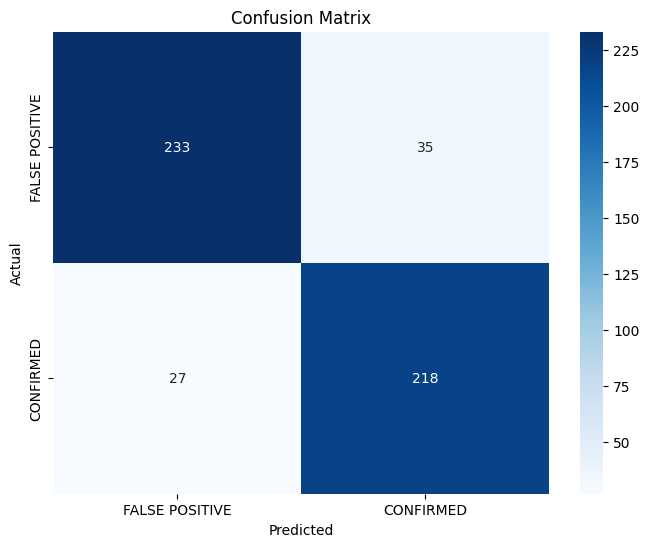

In [10]:
labels = ['FALSE POSITIVE', 'CONFIRMED']

Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs >= 0.5).astype(int).flatten()
Y_true = Y_test.values.astype(int).flatten() 

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_true]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()